In [2]:
from __future__ import division
from functools import partial
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

from performance import *
from tqdm import tqdm

# Purpose of the Notebook

Part 1: Sharpe Ratio Parity

Part 2: Distance Weighted SR Portfolio

In [3]:
country_etfs = pd.read_csv('../Data/country_data/ETF_adj_close.csv',index_col=0)
country_etfs.index = pd.to_datetime(country_etfs.index)
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('Emerging_MOM_Factor',start = '2000-01-01').read()[0]
ff6 = pd.concat([ff5,ff_mom],axis=1)

In [4]:
# find weekly return - take last date and pct-change
country_returns = country_etfs.resample('W').last().pct_change()
# country_returns.index = country_returns.index.to_period('W')

In [5]:
equity_factors = pd.read_pickle('../Outputs/equity/equity_country_factors_rf.pkl')

equity_factors = equity_factors[equity_factors.momentum.notnull()]

# Step 1: Obtain Sharpe Ratio and Covariance Matrix per Factor per time step 

Rolling Window = 52 weeks?

In [6]:
sigma_p=0.05

In [7]:
def calc_SR(s, n = 52):
    return s.mean()/s.std() * (n**0.5)

def calc_lambda(SR, sigma = sigma_p):
    top_ = np.sqrt((SR**2).sum(axis=1))
    lambda_ = top_/2/sigma
    return lambda_

def calc_weight(SR, lambda_,sigma):
    temp = SR.dropna()
    rc = temp.divide(lambda_t.loc[temp.index],axis=0)/2
    w = rc/sigma
    
    return rc, w

factors = ['size', 'value', 'momentum', 'market-rf']
sigma_nt = equity_factors[factors].rolling(52).std()
SR_t = equity_factors[factors].rolling(52).apply(calc_SR)
lambda_t = calc_lambda(SR_t)
rc, w = calc_weight(SR_t,lambda_t, sigma_nt)
w = w.divide(w.abs().sum(axis=1),axis=0)
sr_return = np.sum(np.multiply(w.dropna(),equity_factors.loc[w.dropna().index][factors]),axis=1)

# Step 1.a: Exclude Market

Rolling Window = 52 weeks?

Text(0.5, 1.0, 'Factor Portfolio Cum. Performance')

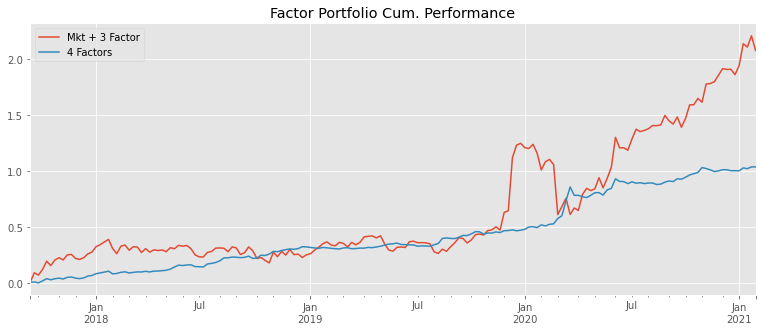

In [8]:
factors = ['size', 'value', 'momentum']
sigma_nt = equity_factors[factors].rolling(52).std()
SR_t = equity_factors[factors].rolling(52).apply(calc_SR)
lambda_t = calc_lambda(SR_t)
rc1, w1 = calc_weight(SR_t,lambda_t, sigma_nt)
w1 = w1.divide(w1.sum(axis=1),axis=0)

mkt = equity_factors.loc[w1.dropna().index,'market-rf'] 

sr_return1 = np.sum(np.multiply(w1.dropna(),equity_factors.loc[w1.dropna().index][factors]),axis=1)+mkt
(np.cumprod(1 + sr_return1)-1).plot(figsize = (13,5))
(np.cumprod(1 + sr_return)-1).plot()
plt.legend(['Mkt + 3 Factor','4 Factors'])
plt.title('Factor Portfolio Cum. Performance')

Text(0.5, 1.0, 'Factor Portfolio Cum. Performance')

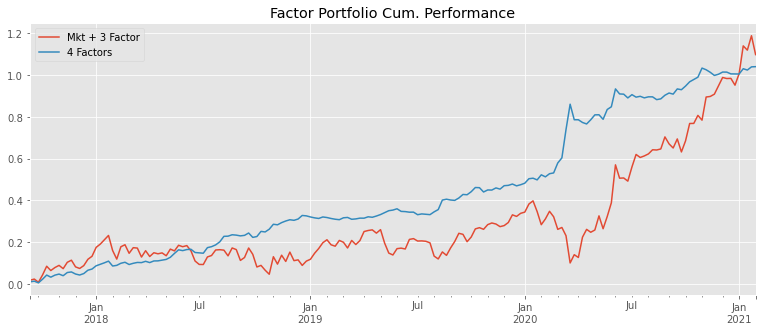

In [10]:
factors = ['size', 'value', 'momentum']
sigma_nt = equity_factors[factors].rolling(52).std()
SR_t = equity_factors[factors].rolling(52).apply(calc_SR)
lambda_t = calc_lambda(SR_t)
rc1, w1 = calc_weight(SR_t,lambda_t, sigma_nt)
w1 = w1.divide(w1.abs().sum(axis=1),axis=0)

mkt = equity_factors.loc[w1.dropna().index,'market-rf'] 

sr_return1 = np.sum(np.multiply(w1.dropna(),equity_factors.loc[w1.dropna().index][factors]),axis=1)+mkt
(np.cumprod(1 + sr_return1)-1).plot(figsize = (13,5))
(np.cumprod(1 + sr_return)-1).plot()
plt.legend(['Mkt + 3 Factor','4 Factors'])
plt.title('Factor Portfolio Cum. Performance')

## Performance

Text(0.5, 1.0, 'Three Factor Portfolio Performance 2017-2020')

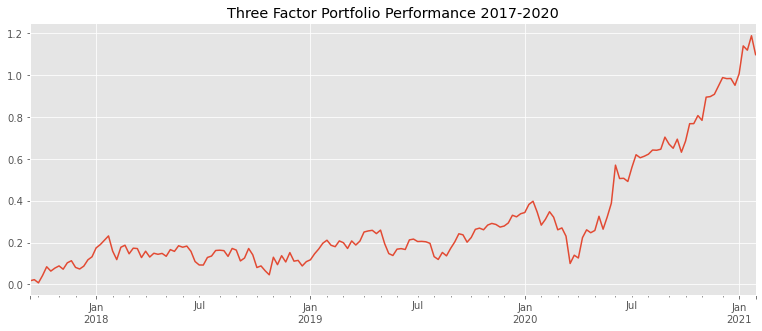

In [11]:
(np.cumprod(1 + sr_return1)-1).plot(figsize = (13,5))
plt.title('Three Factor Portfolio Performance 2017-2020')

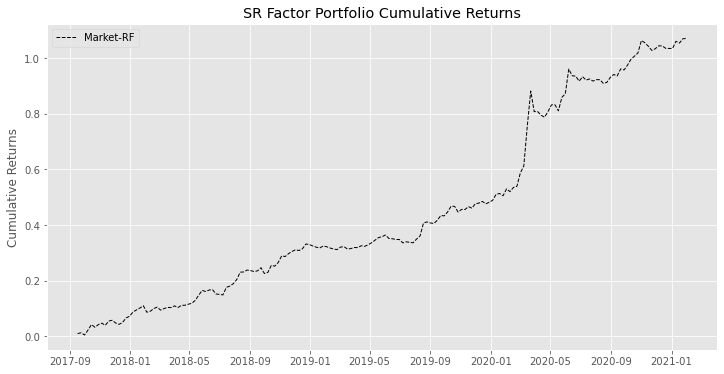

In [12]:
all_port_cum_ret_df = calc_cum_returns(sr_return.to_frame(name='SR'))

# Plot cumulative returns
plot_perf(perf=[all_port_cum_ret_df[x] for x in list(all_port_cum_ret_df.columns.values)[:-1]], \
          perf_bm=all_port_cum_ret_df['SR_cum_ret'], label=['SR'], \
          title='SR Factor Portfolio Cumulative Returns')

## 2. Cluster Tracking Portfolio

min $(g-w\cdot h)^T V_{country} (g-w\cdot h)$

with w_cluster = 0

In [13]:
ref_port = sr_return1

In [14]:
# first try a non-rolling one
# v_cntry = country_returns.cov()

In [15]:
cluster = pd.read_pickle('../Outputs/country_clusters/clusters_equity_etf_full.pkl')
cluster_map = cluster.set_index('Countries').to_dict()['cluster_label']

In [16]:
def obj_(g, V, bm):
#     bm = bm.values.reshape(bm.shape[0],1)
#     bm = np.repeat(bm,g.shape[0],axis=1)
    bm = bm.mean()
    return (g-bm) @ V @ (g-bm).T

def cluster_constraints(returns, cluster_map):
    cmap = returns.columns.map(cluster_map)
    cmap = np.matrix([(cmap==c)*1 for c in cmap.unique()]).T
    lb = np.repeat(np.matrix([0.]),4,axis=1)
    ub = np.repeat(np.matrix([0.01]),4,axis=1) # upper and lower bounds
    group_cons = list()
#     lb, ub = 0., 0.01
    lbdict = {'type': 'ineq', 
              'fun': lambda x: np.sum(np.sum(x*cmap,axis=1) - lb)}
    ubdict = {'type': 'ineq', 
              'fun': lambda x: np.sum(ub-np.sum(x*cmap,axis=1))}
    group_cons.append(lbdict); group_cons.append(ubdict)
    return group_cons

def opt(cntry_rtn,V,bm):    
    noa = len(cntry_rtn.columns)
    guess = noa * [1. / noa,] # equal-weight for initial guess
#     bnds = tuple((0, 1) for x in range(noa))
#     cons = cluster_constraints(cntry_rtn, cluster_map)
    cmap = cntry_rtn.columns.map(cluster_map)
    lb = 0
    ub = 0.005
    cons = [
            {'type': 'ineq', 
              'fun': lambda x: np.sum(x[cmap==0])-lb},
            {'type': 'ineq', 
              'fun': lambda x: np.sum(x[cmap==1])-lb},
            {'type': 'ineq', 
              'fun': lambda x: np.sum(x[cmap==2])-lb},
            {'type': 'ineq', 
              'fun': lambda x: np.sum(x[cmap==3])-lb},
            {'type': 'ineq', 
              'fun': lambda x: ub-np.sum(x[cmap==0])},
            {'type': 'ineq', 
                  'fun': lambda x: ub-np.sum(x[cmap==1])},
            {'type': 'ineq', 
                  'fun': lambda x: ub-np.sum(x[cmap==2])},
            {'type': 'ineq', 
                  'fun': lambda x: ub-np.sum(x[cmap==3])}
    ] #{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.},
    opt = minimize(obj_, guess, args=(V,bm), method='SLSQP', 
                   constraints=cons, tol=1e-10)
    return opt.x

def opt_multi(cntry_rtn, bm, window = 52):
    dates = cntry_rtn.index
    w_ = []
    for d in tqdm(range(len(dates)-window)):
        date_idx = dates[d:d+window+1]
        try:
            bm_t = bm.loc[date_idx]
            cnt_t = cntry_rtn.loc[date_idx]
            v_t = cnt_t.cov()
            res = opt(cnt_t,v_t,bm_t)
            w_.append(res)
        except:
            continue
    w_ = np.matrix(w_)
    final_w = pd.DataFrame(w_,columns = cntry_rtn.columns, index = dates[-w_.shape[0]:])
    return final_w

In [17]:
cluster_cons_w  = opt_multi(country_returns.loc[equity_factors.index],ref_port)

100%|██████████| 176/176 [01:22<00:00,  2.13it/s]


Text(0.5, 1.0, 'Cluster Constrained Country Portfolio Performance 2018-2021')

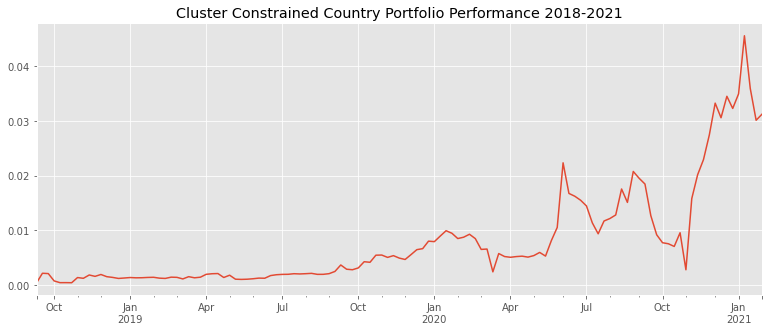

In [18]:
cluster_cons_ret = (cluster_cons_w * country_returns.loc[cluster_cons_w.index]).sum(axis=1)
(np.cumprod(1 + cluster_cons_ret)-1).plot(figsize = (13,5))
plt.title('Cluster Constrained Country Portfolio Performance 2018-2021')

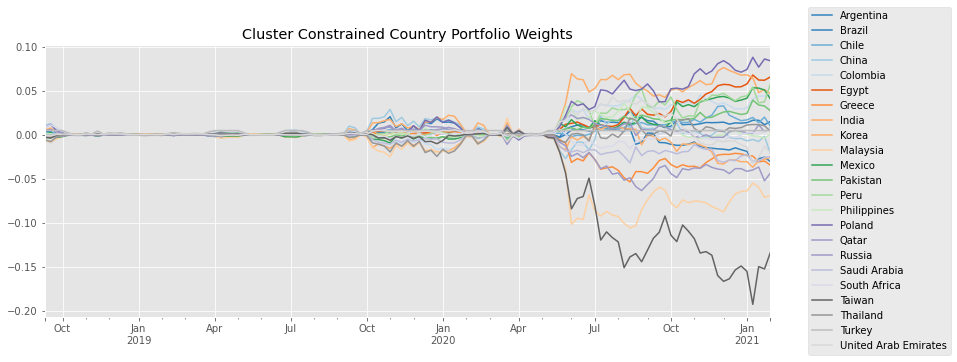

In [19]:
cm = plt.get_cmap('tab20c')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/23) for i in range(23)])
cluster_cons_w.plot(figsize=(13,5),ax=ax)
plt.title('Cluster Constrained Country Portfolio Weights')
plt.legend(bbox_to_anchor=[1.15, 0.5], loc='center');

<AxesSubplot:>

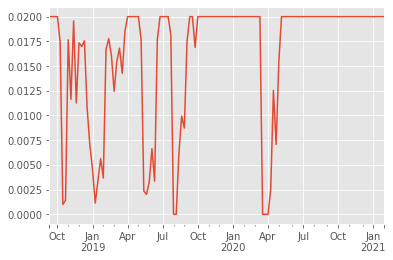

In [20]:
cluster_cons_w.sum(axis=1).plot()

In [21]:
# def cluster_constraints(returns, cluster_map):
#     cmap = returns.columns.map(cluster_map)
#     obs = len(returns)
#     group_cons = list()
#     for c in cmap.unique():
# #         lb = np.repeat(np.matrix([0.]),obs,axis=1)
# #         ub = np.repeat(np.matrix([0.01]),obs,axis=1) # upper and lower bounds
#         lb, ub = 0., 0.01
#         lbdict = {'type': 'ineq', 
#                   'fun': partial(np.sum(x[cmap==c]) - lb)}
#         ubdict = {'type': 'ineq', 
#                   'fun': partial(ub - np.sum(x[cmap==c]))}
#         group_cons.append(lbdict); group_cons.append(ubdict)
#     return group_cons

## Distance-Based

In [22]:
gdp_dist = pd.read_pickle('../Outputs/macroeconomics/gdp_distance.pickle')
vol_dist = pd.read_pickle('../Outputs/macroeconomics/vol_distance.pickle')

In [23]:
gdp_dist = gdp_dist.loc['2017-09-17':]
vol_dist = vol_dist.loc['2017-09-17':]

In [25]:
dist_weight, didx = [], []
macro_w = np.matrix([2/3,1/3])
for d in range(len(SR_t)):
    try:
        date = SR_t.index[d]
        drng = SR_t.index[0:d]
        
        w_gdp = gdp_dist[date]
        normed_w_gdp = w_gdp.divide(w_gdp.sum())
        new_w_gdp = normed_w_gdp.dropna().values @ w1.loc[drng].dropna().values
        
        w_vol = vol_dist[date]
        normed_w_vol = w_vol.divide(w_vol.sum())
        new_w_vol = normed_w_vol.dropna().values @ w1.loc[drng].dropna().values
        
        didx.append(date)
        dist_weight.append(macro_w @ np.c_[new_w_gdp,new_w_vol].T)
    except:
        print(d)

223
224
225
226
227


In [26]:
dist_SR_w = pd.DataFrame(np.array(dist_weight).squeeze(),index = didx, columns = factors)
dist_SR_rtn = np.sum(np.multiply(dist_SR_w.dropna(),equity_factors.loc[dist_SR_w.dropna().index][factors]),axis=1)
dist_SR_rtn = mkt[mkt.index.isin(dist_SR_rtn.index)] + dist_SR_rtn

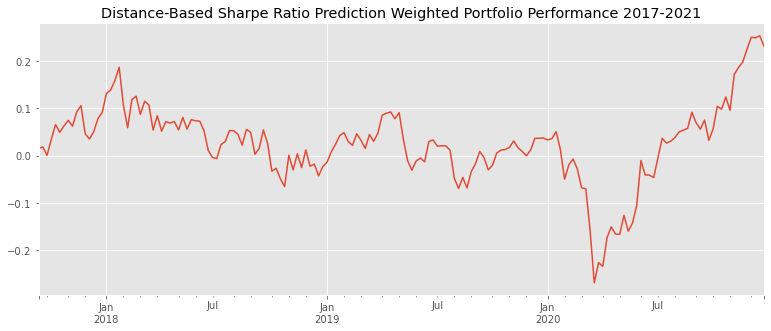

In [27]:
((1+dist_SR_rtn).cumprod()-1).dropna().plot(figsize = (13,5))
plt.title('Distance-Based Sharpe Ratio Prediction Weighted Portfolio Performance 2017-2021');

<AxesSubplot:>

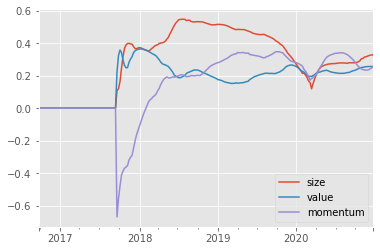

In [28]:
dist_SR_w.plot()

# Comparison

In [29]:
portfolios = [sr_return1, cluster_cons_ret, 
              dist_SR_rtn]
all_sr = pd.concat(portfolios,axis=1)
all_sr.columns = ['SR', 'Cluster SR',
                 'Macro Timing']

perf_df = {}
for c in all_sr:
    res = calc_performance(all_sr[c], log_ret = False, time = 52)
    perf_df[c] = res

dfidx = ['Ann Return','Ann Std','Ann SR',
         'Skewness','Kurtosis','Max Drawdown','Max DD Date']
perf_df = pd.DataFrame(perf_df, index = dfidx)
perf_df

,SR,Cluster SR,Macro Timing
Ann Return,24.32,1.29,6.49
Ann Std,21.37,1.95,22.02
Ann SR,1.14,0.66,0.29
Skewness,0.01,1.29,-0.63
Kurtosis,2.0,8.07,3.03
Max Drawdown,21.29,1.91,38.44
Max DD Date,2020-03-22,2020-11-01,2020-03-22


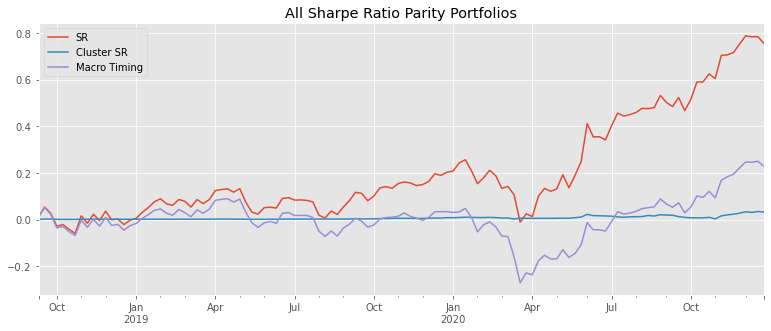

In [31]:
((1+all_sr.dropna()).cumprod()-1).plot(figsize=(13,5), title = 'All Sharpe Ratio Parity Portfolios');